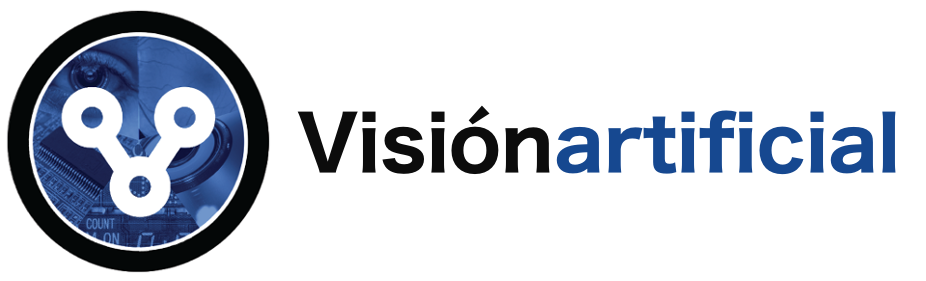

# OpenCV 

### para a materia de Visión Artificial do Grao de Robótica. EPSE de Lugo.

<hr style = "border: none; height: 4px; background-color: # D3D3D3" />

# 3.1 Introdución á visión estéreo

O obxectivo da visión estéreo é recuperar información 3D a partir de imaxes 2D. Un obxectivo ambicioso, non?

Como dixemos en cadernos anteriores, utilizar unha soa imaxe non é suficiente para inferir información 3D da escena, xa que todos os puntos 3D que se atopan no raio parten do centro óptico da cámara e pasan por un determinado píxel **proxéctanse a ese mesmo píxel**. Polo tanto, non podemos inferir que a profundidade a partir dunha soa unha imaxe, pero aínda hai claves visuais que permiten algún tipo de inferencia para a profundidade como **sombras, textura, enfoque, perspectiva, movemento, fluxo óptico** e **oclusión**:$\\[10pt]$


<table>
    <tr>
        <td><img src="./images/shading.png" width="330" align="left"/></td>
        <td><img src="./images/texture.png" width="210" align="rigth"/></td>
    </tr>
    <tr>
        <td>Sombras</td>
        <td>Textura</td>
    </tr>
    <tr>
        <td><img src="./images/focus.png" width="300" align="left"/></td>
        <td><img src="./images/perspective.png" width="330" align="rigth"/>$\\[10pt]$</td>
    </tr>
    <tr>
        <td>Enfoque</td>
        <td>Perspectiva</td>
    </tr>
</table>

En certo sentido, podemos inferir algunha información 3D destas imaxes únicas. Pero, **poderíamos usar máis dunha imaxe para superar estas limitacións?** A resposta é si, por suposto!

***Visión estéreo*** é o proceso de **extraer información 3D** (profundidade, forma, tamaño e localización dos obxectos no espazo) **a partir de varias imaxes dunha escena**. Este enfoque utilízase en múltiples aplicacións como sistemas de asistencia ao condutor, navegación de robots, mapeo de escenas, inferencia de profundidade para entretemento e, en xeral, calquera aplicación onde a profundidade dos obxectos na escena sexa unha información valiosa.

De feito, o uso dun sistema de visión estéreo foi unha vantaxe evolutiva para a maioría dos animais (**incluídos os humanos**) co fin de interactuar de forma máis eficiente co medio. Ben, a natureza adoita ser un exemplo sabio a seguir...

Nestas dúas imaxes pódese ver parte da Praza Vermella de Moscova, pero vista desde **puntos de vista lixeiramente diferentes**:
<img src="./images/stereo.jpg" width="400" />

Aínda que a diferenza é sutil, abonda con proporcionar información sobre que elementos están máis preto da cámara e, nalgún sentido, cales son os tamaños dos obxectos da escena. Como describiremos máis adiante, denotaremos por **disparidade**: *a distancia na imaxe entre dous puntos correspondentes na imaxe esquerda e dereita*. Este valor da disparidade para un determinado punto **é inversamente proporcional á distancia desde a cámara ata o punto** (é dicir, a profundidade do punto!).

Neste caderno, presentaremos como funciona a visión estereoscópica abordando:

- Introdución á reconstrución de escenas (<a href="#311">sección 3.1.1</a>)
- Triangulación e disparidade (<a href="#311">sección 3.1.1</a>)
- Restricións para as correspondencias (<a href="#311">sección 3.1.1</a>)

## Contexto do problema - Reconstrución da escena mediante visión estéreo

Tendo dúas cámaras separadas, podemos reconstruír unha escena (obter un mapa 3D de tamaño real) coñecendo a **disparidade** de cada punto e os parámetros intrínsecos da cámara:

<img src="./images/stereo-reconstruction.png" />$\\[5pt]$

Se observas con atención notarás que estas dúas imaxes mostran algunhas zonas negras nos bordes. Iso é porque as imaxes foron procesadas **para eliminar a distorsión** (recorda o caderno anterior), e iso é porque as ecuacións estéreo só funcionan en imaxes sen distorsión, de aí a importancia de calibrar as cámaras que estamos a usar para esta tarefa!

Neste caso particular, seguiuse un enfoque **estéreo denso** no que se calculou a profundidade **para cada píxel** das imaxes para que se consiga a reconstrución 3D para a maior parte da escena. Alternativamente, un enfoque **estéreo disperso** só atopa a profundidade en certos puntos (puntos clave, por exemplo) que pode ser suficiente para determinadas aplicacións (como a navegación de robots, por exemplo).

Para este caderno utilizaremos coñecementos doutras partes do curso como:
- detección e coincidencia de puntos clave,
- como transformar un mapa de profundidade nun mapa 3D usando o modelo da cámara,
- ou calibración da cámara.

A nosa tarefa neste capítulo é comprender toda a teoría que hai detrás da visión estereoscópica para **xerar mapas 3D** (incluso para fotos tomadas co noso teléfono móbil).

Só dous últimos detalles sobre a reconstrución da escena:
- non require dúas cámaras, pero si, polo menos **dúas vistas diferentes da escena**.
- xeneralízase ao uso de máis de dúas cámaras/vistas, é dicir, **non se restrinxe a só dúas vistas**.

Agora, imos comezar!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
from mpl_toolkits.mplot3d import Axes3D

images_path = './images/'

## 3.1.1 Introdución á reconstrución de escenas <span id=311></span>

Tendo varias imaxes dunha escena, é posible **crear un mapa 3D desa escena mediante técnicas de visión estéreo**. Como se dixo antes, isto non precisa de dúas cámaras, **senón de dúas vistas diferentes da escena**. Neste sentido, temos diferentes posibilidades:

- **Sistema StereoVision** (o estándar)
    - Dúas cámaras.
    - Imaxes tomadas simultaneamente.
    - A pose relativa das cámaras é **coñecida**.
    
<img src="./images/stereovision.jpg" width="400" />

- **Estrutura-desde-Movemento** (SFM)
    - Unha ou varias cámaras de diferentes lugares descoñecidos, normalmente cunha liña de base grande (canto máis, mellor!).
    - Usa a técnica [Bundle Adjustment](https://en.wikipedia.org/wiki/Bundle_adjustment) para determinar as coordenadas 3D.
    - As cámaras poden ser diferentes (é dicir, a súa matriz de calibración $K$ non precisa ser igual).
    
<img src="./images/SFM.png" width="500" />

- **MonoVisual SLAM** (localización e mapeo simultáneos)
    - Unha cámara movéndose nun ambiente. Cada dous cadros forman un par estéreo.
    - Igual SFM pero secuencialmente, unha liña base pequena e en tempo real (por exemplo, un dron que grava un vídeo dunha escena mentres voa).

<img src="./images/slam.png" width="500" />

En liñas xerais, o **obxectivo da visión estéreo** é atopar o punto 3D correspondente a calquera píxel do par de imaxes. Noutras palabras, atopar a intersección de dúas liñas:

<img src="./images/intersection.png" width="500" />

Isto parece sinxelo, pero aparecen algúns problemas:

- **Coincidencia de características:** En primeiro lugar, é necesario detectar as características dunha imaxe e as súas correspondencias na outra imaxe (por exemplo, Harris + NCC, SIFT, ORB, ...). Podes lembrar os problemas cos que nos enfrontamos nos cadernos anteriores para atopar correspondencias precisas e correctas. Os puntos clave ruidosos levan a puntos 3D imprecisos e as correspondencias incorrectas xeran *outliers* no mapa 3D, como comentaremos máis adiante neste caderno.$\\[5pt]$

- **Triangulación Xeométrica:** Isto implica calcular a profundidade do punto dadas as características correspondentes. Aprenderemos como se fai isto na seguinte sección.$\\[5pt]$

- Perfecto **coñecemento da pose relativa** entre as cámaras, dado pola **Xometría epipolar** (próximo caderno).$\\[5pt]$


## 3.1.2 Triangulación e disparidade <span id=312></span>

Comecemos describindo como obter as coordenadas 3D dun determinado punto a partir dos seus píxeles correspondentes nas imaxes. Para iso, utilizaremos os coñecementos do caderno onde indicamos o modelo de cámara, e asumiremos **unha configuración de cámara ideal**, é dicir:

- Cámaras idénticas e paralelas
- Cámara dereita ao longo do eixe $X_l$ a unha distancia $b$ (chamada *línea de base*)

Non importa que, na práctica, as nosas cámaras non estean exactamente colocadas como se describe, porque sempre podemos **rectificar as imaxes** mediante a chamada **xeometría epipolar**, que se abordará no seguinte caderno. Pero, polo momento, supoñamos que temos unha cámara estéreo ideal.$\\[5pt]$

Neste caso, a relación xeométrica entre as dúas cámaras di o seguinte:$\\[5pt]$

$$X_l = \mathbf{R}X_r + \mathbf{t} \qquad \mathbf{R} = \mathbf{I} \qquad \mathbf{t} = \begin{bmatrix}b \\ 0 \\ 0 \end{bmatrix}$$

<img src="./images/triangulation1.png" />

Ten en conta que a pose da cámara esquerda indicada por $X_l$ está relacionada coa pose da cámara dereita $X_r$ a través dunha matriz de rotación e un vector de translación, que, neste caso, son a **matriz de identidade** e un **translación** única no eixe $X$, respectivamente. Como tamén podedes ver, nesta configuración os píxeles correspondentes a un determinado punto 3D teñen en común as súas coordenadas *filas*, é dicir, **proxéctanse á mesma liña de píxeles en ambas imaxes: $y_r = y_l$** . Esta propiedade é extremadamente útil cando se buscan correspondencias.

Así, dado un punto 3D $\bf{P} = (X,Y,Z)$, podemos obter as coordenadas proxectadas tanto nas imaxes da esquerda como da dereita por triangulación como:$\\[5pt]$


<img src="./images/triangulation2.png" width="300" align="left"/>$\\[10pt]$

$$\large{\begin{cases} \frac{x_l}{f} = \frac{X_l}{Z} \\[10pt]  \frac{x_r}{f} = \frac{X_r}{Z} = \frac{X_l - b}{Z} \end{cases}} \normalsize{\xrightarrow{\text{Eliminamos } X_l}  \frac{b}{Z} = \frac{\color{red}{x_l- x_r}}{f} \rightarrow Z = b \frac{f}{\color{red}{d}}} \quad \small{\text{(}d \text{ = disparidade)}}\\[20pt]$$

$$\text{Eixe Y (o mesmo para ambos eixes):} \qquad \frac{y_l}{f} = \frac{y_r}{f} = \frac{Y}{Z} \hspace{6cm}\\[10pt]$$

$$
\begin{align}
\mathbf{P} &= \left[X \quad Y \quad Z\right]^T 
= \left[ Z\frac{x_l}{f} \quad Z\frac{y_l}{f} \quad Z \right]^T  \\
&= \left[ b\frac{x_l}{d} \quad b\frac{y_l}{d} \quad b\frac{f}{d} \right]^T 
= \frac{b}{d}\left[x_l \quad y_l \quad f\right]^T 
\end{align}
\\[30pt]$$


Nesta ecuación introducimos o concepto de **disparidade**, que representa a diferenza na coordenada $x$ dos puntos proxectados en ambas imaxes, é dicir, $d = x_l-x_r$. Ten en conta que a profundidade $\mathbf{Z}$ é inversamente proporcional á disparidade $d$. Ten en conta tamén que, nesta ecuación, **tanto a disparidade como as coordenadas $(x_l,y_l)$ están en metros**, medidos no sensor. Lembra que, se queremos usar píxeles como unidades, temos que facer unha **transformación do sensor da cámara á matriz de imaxe**:$\\[5pt]$
<img src="./images/sensor_matrix.png" width="600"/>$\\[5pt]$

$$\begin{eqnarray} 
    u & = & xk_x + u_o \rightarrow x & = & (u - u_0)/k_x \\ 
    v & = & yk_y + v_o \rightarrow y & = & (v - v_0)/k_y 
\end{eqnarray} \longrightarrow d = x_l - x_r = \frac{(u_l - u_r)}{k_x} = \frac{d'}{k_x} \qquad d' \ \text{significa disparidade en pixeles}\\[15pt]$$

Para que cheguemos a:

$$
\boxed{\mathbf{P} = \frac{b}{d}\left[x_l \quad y_l \quad f\right]^\texttt{T} 
             = \frac{bk_x}{d'}\left[\frac{(u_l - u_0)}{k_x}\quad \frac{(v_l - v_0)}{k_y}\quad f\right]^\texttt{T} 
            = \frac{b}{d'}\left[(u_l - u_0)\quad \frac{k_x}{k_y}(v_l - v_0)\quad k_xf\right]^\texttt{T}}\\[30pt]
$$

Como podes ver, os parámetros intrínsecos da cámara $(u_0,v_0,k_x,k_y,f)$, así como a *línea de base* (que é un parámetro extrínseco), son necesarios para calcular as coordenadas 3D dunha correspondencia en dous imaxes. **Por iso necesitamos calibrar a cámara**.

### Precisión da reconstrución

Agora sabemos como obter puntos 3D das súas correspondencias, podemos preguntarnos **que precisión é o punto 3D reconstruído?** Ben, a principal fonte de erro provén das **imprecisións na detección dos puntos**, que provocan erros nas coordenadas 3D, xa que ao calcular a profundidade, tanto a distancia focal como a liña base teñen valores fixos e a única **variable** é a **disparidade**. Por suposto, os erros na determinación da distancia focal ou da liña de base inflúen no erro final, pero pódense estimar con máis precisión. $\\[5pt]$

$$Z = b\frac{f}{d} \rightarrow \text{erro na deteccion dos puntos} \rightarrow \text{erro na disparidade} \rightarrow \text{erro na profundidade}\\[5pt]$$


Así, se temos un erro de disparidade $\Delta d$, é posible calcular como este erro se propaga a $Z$ calculando a derivada da coordenada con respecto á profundidade:$\\[5pt]$

$$Z = b\frac{f}{d} \rightarrow \frac{\Delta Z}{\Delta d} = -\frac{bf}{d^2} \longrightarrow \Delta Z = -\frac{bf}{d}\Delta d = - \frac{Z^2}{fb}\Delta d\\[5pt]$$

Polo tanto, dado un erro de disparidade $\Delta d$, o erro en profundidade **crece cuadráticamente** co valor $Z$. Isto implica que para obxectos máis próximos ($\downarrow Z$), a influencia do erro de disparidade vai ser menor. É dicir, a posición dos puntos máis próximos á cámara estimarase con máis precisión que a dos puntos máis afastados.

Por outra banda, para aumentar a precisión dos puntos 3D, poderíase aumentar a liña de base (é dicir, separando as cámaras), pero isto pode causar máis dificultades para atopar correspondencias xa que **as imaxes deben superpoñerse!** De feito, os sistemas estéreo usado para aplicacións ao aire libre adoita presentar liñas de base máis amplas xa que están destinados a utilizar puntos afastados, mentres que os pares estéreo de liña base pequena resérvanse para aplicacións en interiores. $\\[5pt]$


<img src="./images/triangulation4.png" width="900"/>$\\[5pt]$

## 3.1.3 Restricións para a correspondencia <span id=313></span>

A primeira e unha das decisións máis importantes antes de comezar a nosa tarefa é decidir **que características imos detectar e coincidir**. Podemos combinar todos os píxeles das imaxes (*estéreo denso*), só os puntos clave (*estéreo dispersión*) ou outras características da imaxe como bordes, segmentos, rexións, etc. E tamén temos que decidir **que descritor** utilizaremos (Harris, SIFT/ORB/SURF para puntos clave, etc).

Un dos criterios máis importantes á hora de elixir isto é **robusteza de coincidencia**, é dicir, deben ser o suficientemente distintivos como para evitar calquera coincidencia incorrecta, xa que isto pode resultar catastrófico para a nosa aplicación. Normalmente, estas coincidencias incorrectas chámanse **outliers** e deben evitarse na medida do posible, se non, xeraremos puntos 3D *inventados*:


<img src="./images/correspondence1.png" width="500"/>$\\[5pt]$

Como podes ver na imaxe, se coincidimos o punto $d$ da imaxe da esquerda co punto $a'$ da dereita **xeraremos un punto 3D na escena que non pertence a ningún obxecto dela**. Se máis tarde empregamos ese punto 3D para localizar a nosa cámara, por exemplo, obteremos unha estimación errónea de tal localización.

Para filtrar os valores atípicos, podemos aplicar algunhas restricións do entorno:

### Permítese a disparidade máxima e mínima

Esta é unha limitación importante, xa que podes establecer facilmente a **disparidade máxima e mínima** para unha determinada área da escena, dependendo da profundidade dos obxectos nela, así como da liña base e da distancia focal do noso par estéreo. Deste xeito, se unha coincidencia **presenta unha disparidade fóra dos nosos límites preestablecidos será descartada**.

<img src="./images/correspondence2.png" width="500"/>$\\[5pt]$


### Continuidade das superficies

No mundo real, **as superficies son contínuas**, é dicir, a profundidade cambia suavemente. Isto só se viola nos bordes de oclusión, que se poden detectar usando un detector de bordes como Canny. Pero ademais dos bordes, haberá unha alta probabilidade de que **os píxeles próximos teñan unha profundidade (e, polo tanto, disparidade) semellantes**.

<img src="./images/correspondence3.png" width="400"/>$\\[5pt]$

### Singularidade

Cada píxel da imaxe é a proxección de **só un punto en 3D**. Noutras palabras, un píxel dunha imaxe só terá un píxel correspondente na outra imaxe. Esta é a razón pola que, se lembras, descartamos as coincidencias ambiguas con SIFT establecendo un determinado limiar para que a mellor correspondencia debe estar o suficientemente afastada do resto de posibilidades.

<img src="./images/correspondence4.png" width="400"/>$\\[5pt]$

### Ordenación e xeometría epipolar

Abordaremos estas restricións en futuros cadernos, pero a grandes liñas, o primeiro indica que os puntos correspondentes ao longo dunha liña (chamada liña epipolar) **deben atoparse na mesma orde en ambas as imaxes** (con algunhas excepcións).

<img src="./images/correspondence5.png" width="300"/>$\\[5pt]$

A segunda está baseada na chamada xeometría epipolar e indica que o punto correspondente para un determinado píxel nunha imaxe **debe estar nunha soa liña** (a liña epipolar de novo) na outra imaxe, reducindo así efectivamente o área de busca de 2D a 1D.

Pero non te preocupes por isto agora mesmo, poremos a nosa atención aquí no próximo caderno.

**Agora imos traballar coa visión estéreo!**

### **<span style="color:green"><b><i>TAREFA 1: Tomando e cargando imaxes para facer estéreo</i></b></span>**

Neste exercicio imos simular un sistema estéreo ideal usando os nosos smartphones para reconstruír unha escena con estéreo disperso (poucos puntos). Alternativamente, ofrécese un par de imaxes por se non quere usar as túas propias.

En primeiro lugar, imos **tomas 2 imaxes** (esquerda e dereita) de calquera escena (por exemplo, colocar algúns obxectos nunha mesa). Para simular as condicións necesarias para a triangulación, intenta mover a cámara hacia á dereita pero **sen xirarla** (recorda que nunha configuración ideal, a matriz de rotación entre as cámaras é a identidade e a traslación só é un desfase na dirección $X$). Mide e anota a distancia que moviches a cámara entre as dúas imaxes (esta é a nosa *línea de base*).

<img src="./images/ideal_conf_example.png" width="300"/>$\\[5pt]$

Para ser precisos, debemos **rectificar** as imaxes, pero ese proceso explicarase no seguinte caderno. De momento, intentemos facer estéreo sen rectificar as imaxes, pero tendo en conta que **os resultados non serán moi precisos**, porque non se eliminará a distorsión e a configuración espacial das vistas non será a perfecta. Isto eventualmente implica que os **píxeles correspondentes non estarán na mesma coordenada horizontal**, senón preto dunha.

**Agora, carga as imaxes da esquerda e da dereita**.

*Nota: Lembra que podes usar os exemplos.*

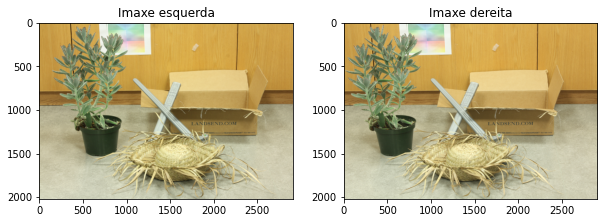

In [2]:
# Tarefa 1a
# Cargamos as imaxes
# Imaxes do exemplo:
# - iml_sword.png, imr_sword.png
# - iml_lamp.png, imr_lamp.png

im_l = cv2.imread(images_path + 'iml_sword.png')
im_l = cv2.cvtColor(im_l, cv2.COLOR_BGR2RGB)

im_r = cv2.imread(images_path + 'imr_sword.png')
im_r = cv2.cvtColor(im_r, cv2.COLOR_BGR2RGB)

# Imaxe esquerda
plt.subplot(121)
plt.imshow(im_l)
plt.title('Imaxe esquerda')

# Imaxe dereita
plt.subplot(122)
plt.imshow(im_r)
plt.title('Imaxe dereita');

### **<span style="color:green"><b><i>TAREFA 2: Detección e coincidencia de puntos clave</i></b></span>**

Unha vez que teñamos as nosas imaxes, decidimos utilizar **puntos clave** para realizar estereo. Deste xeito, a reconstrución 3D só mostrará os puntos clave coincidentes, é dicir, será *dispersa*. **A túa tarefa** aquí é usar o teu **detector de puntos clave + descritor** favoritos (escolle un do capítulo 6) para obter un **conxunto de puntos coincidentes** que se utilizarán para a triangulación.

**Utiliza o método escollido para detectar e facer coincidir os puntos en ambas imaxes.**

*Nota: para imaxes grandes,  ORB é unha boa opción pola súa rapidez.*

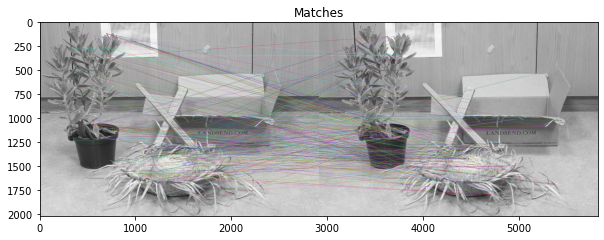

In [5]:
# TAREFA 2
# Detecta puntos clave e busca as coincidencias na outra imaxe

# cargamos as imaxes en gris
gray_l = cv2.cvtColor(im_l,cv2.COLOR_RGB2GRAY)
gray_r = cv2.cvtColor(im_r,cv2.COLOR_RGB2GRAY)

# Detecta os puntos clave ORB usando o método OpenCV
# -- crear o detector ORB
orb = cv2.ORB_create()

# -- detectar puntos clave ORB
kp_l = orb.detect(gray_l,None) # Deixa o segundo none como está
kp_r = orb.detect(gray_r,None) # Deixa o segundo none como está

# -- calcular os descriptores con ORB
kp_l, des_l = orb.compute(im_l, kp_l)
kp_r, des_r = orb.compute(im_r, kp_r)

# Nota: a detección e a descrición pódense facer nunha soa chamada

# Facemos o match
matches = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True).match(des_l,des_r)

# Ordénaos segundo a súa distancia.
matches = sorted(matches, key = lambda x:x.distance)
output = np.zeros_like(gray_r)
# Representa os matches nas duas imaxes
imMatches = cv2.drawMatches(gray_r, kp_r, gray_l, kp_l, matches, output)
plt.figure()
plt.title("Matches")
plt.imshow(imMatches);


### **<span style="color:green"><b><i>TAREFA 3: Filtrando coincidencias e obtención de coordenadas 3D</i></b></span>**

Agora, perfecciona o conxunto de puntos coincidentes para eliminar os valores atípicos. Para iso, estamos a usar a restrición dos **puntos correspondentes situados na mesma *fila* coordenada** (cun certo limiar, lembra que a configuración non é exactamente a ideal!). Usa un limiar (por exemplo, $|v_l-v_r| < th$) para manter só as coincidencias que cumpren a restrición. Tamén podes definir un **rango de disparidade** a ter en conta.

Unha vez que filtras as túas coincidencias, obtén as súas coordenadas 3D aplicando a **triangulación** como se explica anteriormente. Para iso, necesitará os parámetros intrínsecos e extrínsecos do par estéreo ou cámara.

- Se calibraches a túa cámara no último caderno, **utiliza eses parámetros e a mesma cámara**. Se gardaches a súa matriz de calibración como ficheiro `.npy`, cargaa usando [np.load](https://numpy.org/doc/stable/reference/generated/numpy.load.html). En caso contrario, simplemente crea a matriz de calibración como `np.array` ou recupera os valores dos seus parámetros intrínsecos do caderno anterior. *Nota: se é posible, desactiva a configuración de enfoque automático da cámara ao capturar imaxes para a calibración deste exercicio, xa que cambia os parámetros intrínsecos da cámara para diferentes imaxes*.


- Se non calibraches a túa cámara, non te preocupes! **Podes usar as imaxes e os parámetros** que che proporcionamos neste caderno:  
    
<table>
<tr>
    <td>iml_sword.png</td>    
    <td>imr_sword.png</td>    
    <td>parameters</td>    
</tr>    
<tr>
    <td><img src="./images/iml_sword.png" width="300"/></td>    
    <td><img src="./images/imr_sword.png" width="300"/></td>    
    <td>
      $$
      \mathbf{K}_l = \begin{bmatrix} 6872.874 & 0 & 1329.49 \\ 0 & 6872.874 & 954.485 \\ 0 & 0 & 1 \end{bmatrix} \;
      \\
      \mathbf{K}_r = \begin{bmatrix} 6872.874 & 0 & 1623.46 \\ 0 & 6872.874 & 954.485 \\ 0 & 0 & 1 \end{bmatrix} \; 
      \\
      baseline = 17.4724 cm
      $$        
    </td>
</tr>    
<tr>
    <td>iml_lamp.png</td>    
    <td>imr_lamp.png</td>    
    <td>parameters</td>    
</tr>    
<tr>
    <td><img src="./images/iml_lamp.png" width="300"/></td>    
    <td><img src="./images/imr_lamp.png" width="300"/></td>    
    <td>
      $$
      \mathbf{K}_l = \mathbf{K}_r = \begin{bmatrix} 351.32 & 0 & 255.64 \\ 0 & 351.32 & 201.12 \\ 0 & 0 & 1 \end{bmatrix} \;
      \\
      baseline = 0.119 m
      $$
    </td>
</tr>    
</table>

**Que facer?** Mostra unha das imaxes e debuxa nela as coincidencias filtradas (podes usar [cv2.circle](https://docs.opencv.org/4.2.0/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670)). Ademais, realiza a triangulación para obter unha lista das coordenadas 3D de tales puntos.

**Deberías esperar unha saída como esta:**

<img src="./images/matched_keypoints.png"/>

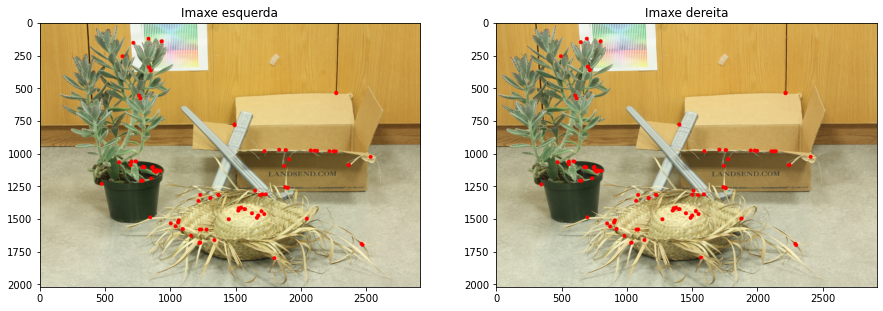

In [7]:
# TAREFA 3
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

# Asumimos que kx/ky=1

# base de datos SWORD
baseline = 17.4724 # cm
intrinsic_l = np.array([[6872.874, 0, 1329.49],[0, 6872.874, 954.485],[0, 0, 1]]) # pixels
intrinsic_r = np.array([[6872.874, 0, 1623.46],[0, 6872.874, 954.485],[0, 0, 1]]) # pixels


d_min = 0
d_max = 20000

# Define auxiliar data structures
points3D = []
color3D  = []

im_points_l = im_l.copy() # imaxe esquerda para a saída
im_points_r = im_r.copy() # imaxe da dereita para a saída

f  = intrinsic_l[0,0]
u0 = intrinsic_l[0,2]
v0 = intrinsic_l[1,2]

# para cada match
for match in matches:
    point_l = kp_l[match.queryIdx].pt # [0] --> x (col), [1] -- > y (row)
    point_r = kp_r[match.trainIdx].pt
    
    # comprobar as coordenadas da fila
    if abs (point_l[1]-point_r[1]) < 10: 
        # print("Match:",point_l,"vs",point_r)
        # comprobar o filtro de disparidade
        d = point_l[0] - point_r[0] # disparidade
        if d < d_max and d > d_min:
            # Debuxa un círculo
            cv2.circle(im_points_l,(int(point_l[0]),int(point_l[1])),15,[255,0,0],cv2.FILLED)
            cv2.circle(im_points_r,(int(point_r[0]),int(point_r[1])),15,[255,0,0],cv2.FILLED)
            
            # Obtén a cor do píxel para 3D
            color3D.append(im_l[int(point_l[1]),int(point_l[0]),:])
            
            # Obter a proxección 3D mediante a triangulación
            points3D.append(( baseline/d * (point_r[0]-baseline),
                              baseline/d * (point_r[1]-baseline),
                              baseline/d * f))

# Mostra cales son as coincidencias que cumpren a condición
plt.subplot(121)
plt.title("Imaxe esquerda")
plt.imshow(im_points_l);

plt.subplot(122)
plt.title("Imaxe dereita")
plt.imshow(im_points_r);

### **<span style="color:green"><b><i>TAREFA 4: Mostrando a nosa escena reconstruída</i></b></span>**

Unha vez calculadas as coordenadas 3D, o último paso é **mostrar unha gráfica de dispersión en cores 3D da escena** utilizando os datos obtidos no paso anterior.

**Exemplo de reconstrución 3D:**
    

<img src="./images/3d_reconstruction.png"/>

/tmp/ipykernel_10722/3854622788.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


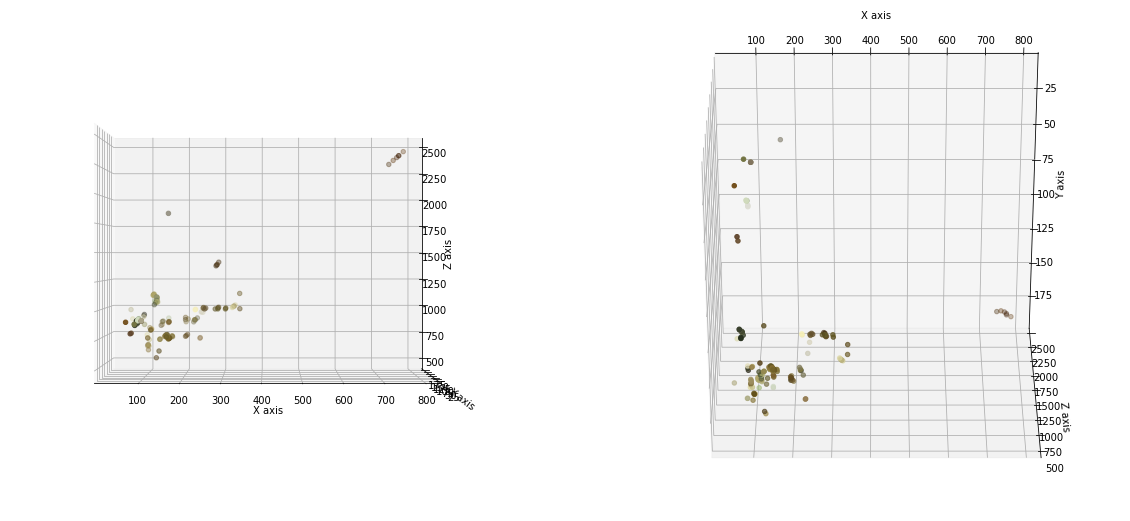

In [9]:
# TAREFA
# %matplotlib notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# Transformar datos en matrices NumPy
points3D = np.array(points3D, dtype=np.int32)
color3D  = np.array(color3D, dtype=np.int32)

# Crear figura
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')

# Nomear eixes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Representa os puntos
ax.scatter(points3D[:,0], points3D[:,1], points3D[:,2], c=color3D/255, cmap="rgb")
ax.view_init(elev=0, azim=-90)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.set_zlabel('Z axis')

# Representa os puntos
ax2.scatter(points3D[:,0], points3D[:,1], points3D[:,2], c=color3D/255, cmap="rgb")
ax2.view_init(elev=-60, azim=-90)

fig.show();

### <font color="blue"><b><i>Reflexionando:</i></b></font>

**Agora estás nunha boa posición para responder a estas preguntas:**

- Precisamos dúas cámaras para facer visión estéreo? Se non, que necesitamos?


     <p style="margin: 4px 0px 6px 5px; color:blue"><i> Necesitanse varias imaxes (minimo duas) o número de camaras non importa. </i></p>

- Enumera cales son os factores que se poden usar para refinar as coincidencias entre os puntos clave de ambas imaxes.


     <p style="margin: 4px 0px 6px 5px; color:blue"><i> Establecer unha disparidade máxima e mínima, continuidade de superficies, singularidade, ordenación e xeometría epipolar.</i></p>
  
- Unha pequena disparidade significa que o obxecto está preto ou lonxe?

        
     <p style="margin: 4px 0px 6px 5px; color:blue"><i> Canto máis lonxe este o obxeto menor é a disparidade. Polo que o obxecto está lonxe. </i></p>


## Conclusión

Fantástico traballo! Ten en conta que a **reconstrución 3D da escena preserva as coordenadas reais** con respecto á posición do sistema estéreo. A unidade de distancia utilizada vén determinada pola matriz da cámara (a distancia focal pode estar en metros, centímetros,...).

Neste caderno aprendiches:

- como funciona a reconstrución estéreo
- Triangulación sobre un par de imaxes rectificadas mediante un sistema de visión estereoscópica ideal
- restricións que se poden aplicar aos puntos de coincidencia para detectar erros

Na práctica, as imaxes utilizadas nos sistemas de visión estéreo **necesitan ser rectificadas** antes de aplicar a triangulación. Isto aprenderase no próximo caderno.